In [1]:
%load_ext autoreload
%autoreload 2

## Focusing on Numerical Cleaning

In [2]:
import sys
sys.path.append('../')
import tokamakTK

import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
#DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]


# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=["unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = "decreasing"


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ","KAREA", "EPS","MEFF","VOL","LCOULOMB",
                          "IP","RHOSTAR","NUSTAR","BETASTAR"] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT","AMIN","BT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ECHMODE","PELLET"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI","PNBI"]
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
features = ['NUSTAR', 'BETASTAR', 'QCYL5', 'HYBRID', 'ENBI', 'VOL', 'POHM',
            'PNBI', 'DWDIA', 'BT', 'NEL', 'PFLOSS', 'KAREA', 'MEFF', 'WFICFORM', 'IP']
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 


features = list(plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power + temperatures  + fast_particles)

In [5]:
"""data_ = DB5[features + ["label", "DATE"]].copy()
print(data_.shape)

# Returns complete features without modifying numerical
data_ = tokamakTK.clean_categorical_data(data_)
print(data_.shape)

# Returns only numerical features
data_ = tokamakTK.clean_numerical_data(data_)
print(data_.shape)

data_["label"] = DB5["label"]
data_ = data_[data_.label.isin(["decreasing"])]
print(data_.shape)""";

``` Python
fig, axs = plt.subplots(1, 2, figsize=(25,10))
fig.subplots_adjust(hspace=0.4)

sns.scatterplot(data=data_, x="RHOSTAR", y="ENBI", hue="TOK", palette="viridis", ax=axs[0])
sns.scatterplot(data=DB5[DB5.label.isin(["decreasing"])], x="RHOSTAR", y="ENBI", hue="TOK", palette="viridis", ax=axs[1]);
```

## Numerical Cleaning: starting all over again 

I am also changing the capacity of the function to be able to receive also categorical data, 
and then return categorical without having it affected. 

In [6]:
df = DB5.copy()

df = tokamakTK.clean_categorical_data(df)

# Data type per feature
num_features = df[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = df[features].select_dtypes(include=['object']).columns.tolist()

df_cat = df[cat_features+["label"]]
df = df[num_features+["DATE","TOK"]]

# Passing DATE to datetime
df["DATE"] = df["DATE"].astype(str).replace(r"(\d{6})00", r"\g<1>01", regex=True)
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

print(df.columns[df.isnull().sum() > 0])

for tokamak in df.TOK.unique():
    for col in df.columns[df.isnull().sum() > 0]:
        # Fill NA with mean per month and year:
        tem = df.groupby(['year', 'month'])[[col]].mean().reset_index()
        tem.rename(columns={col: f'{col}_mean'}, inplace=True)
        # Merge and fill NA:
        df = pd.merge(df, tem, how='left', on=['year', 'month'])
        df.loc[df[col].isna(),col] = df[f'{col}_mean']
        df.drop(f'{col}_mean', axis=1, inplace=True)
# Fill NA per tokamak
df.fillna(df.groupby("TOK").mean(numeric_only=True), inplace=True)
df = df[num_features]
# Fill NA with general table with zeros
#df = df.apply(lambda x: x.fillna(x.mean()))
df.fillna(0, inplace=True)

"""
Metodo se podria mejorar si se hace el fill in del mean 
por tipo de grupo de tokamak; ya sea esferico o no. 
"""

df = StandardScaler().fit_transform(df)
df = pd.DataFrame(df, columns=num_features)

data = pd.concat([df,df_cat], axis=1)

Index(['BEIMHD', 'LHTIME', 'DWDIA', 'WMHD', 'TORQ', 'ELMFREQ', 'ZEFF',
       'ZEFFNEO', 'PRAD', 'ENBI', 'TEV', 'TIV', 'NESOL', 'WFFORM', 'WFICFORM'],
      dtype='object')


In [7]:
data.isnull().sum()

QCYL5        0
BEIMHD       0
LHTIME       0
DWDIA        0
WMHD         0
TORQ         0
KAREA        0
EPS          0
MEFF         0
VOL          0
LCOULOMB     0
IP           0
RHOSTAR      0
NUSTAR       0
BETASTAR     0
AMIN         0
BT           0
ELMFREQ      0
PECRH        0
PICRH        0
ZEFF         0
ZEFFNEO      0
PRAD         0
POHM         0
ENBI         0
PNBI         0
PLTH         0
PFLOSS       0
TAV          0
TEV          0
TIV          0
NESOL        0
WFFORM       0
WFICFORM     0
OMEGACYCL    0
NEL          0
PREMAG       0
HYBRID       0
CONFIG       0
TOK          0
DIVNAME      0
WALMAT       0
DIVMAT       0
LIMMAT       0
ELMTYPE      0
ICSCHEME     0
AUXHEAT      0
ECHMODE      0
PELLET       0
EVAP         0
label        0
dtype: int64

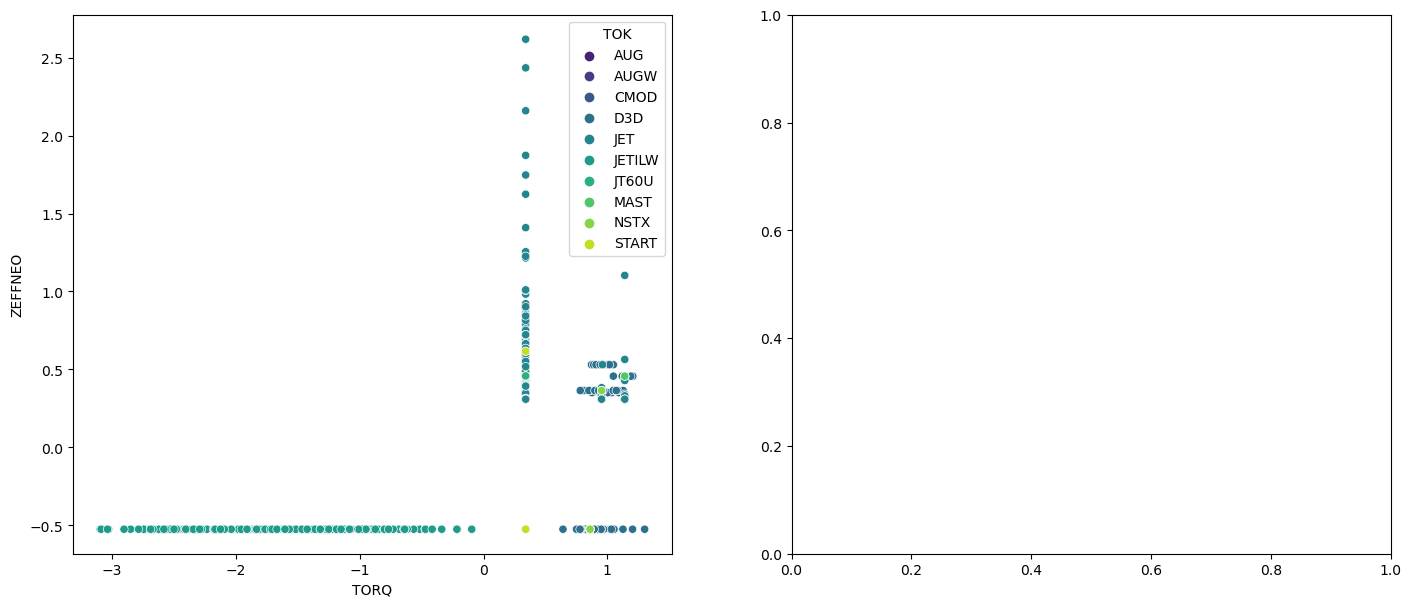

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(17,7))
fig.subplots_adjust(hspace=0.4)

sns.scatterplot(data=data[data.label.isin(["decreasing"])], # Processed vs original
                x="TORQ", y="ZEFFNEO", hue="TOK", palette="viridis", ax=axs[0])
sns.scatterplot(data=DB5[DB5.label.isin(["decreasing"])], 
                x="TORQ", y="ZEFFNEO", hue="TOK", palette="viridis", ax=axs[1]);

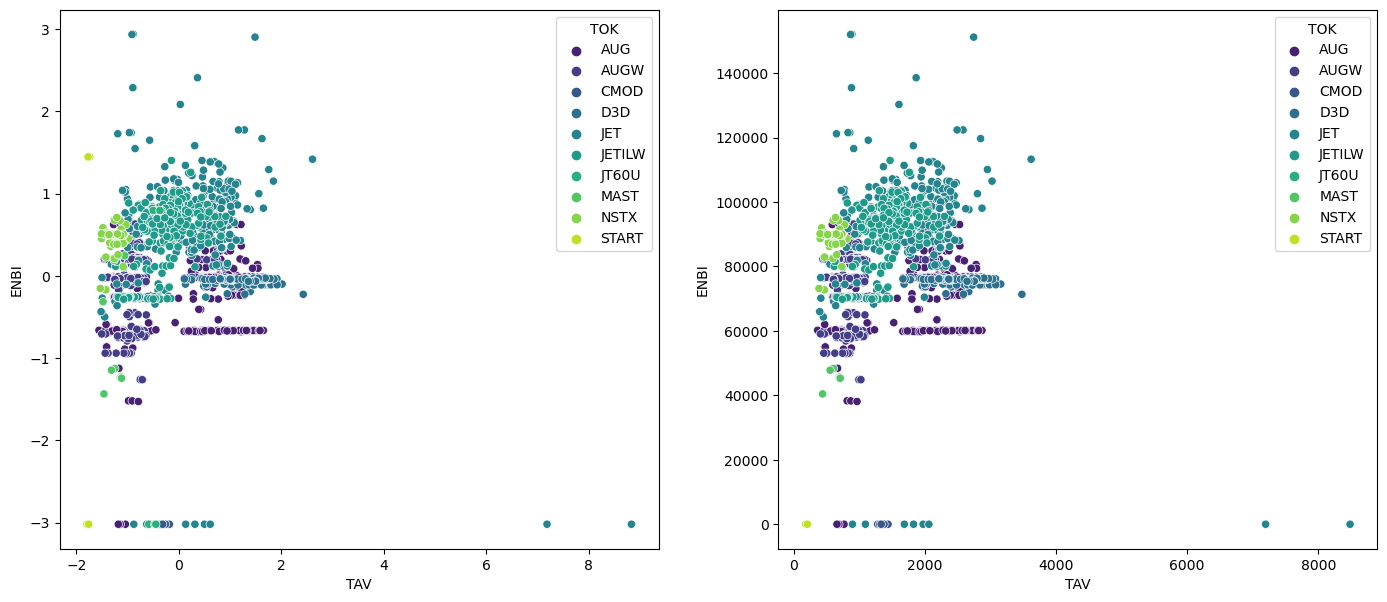

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(17,7))
fig.subplots_adjust(hspace=0.4)

sns.scatterplot(data=data[data.label.isin(["decreasing"])], 
                x="TAV", y="ENBI", hue="TOK", palette="viridis", ax=axs[0])
sns.scatterplot(data=DB5[DB5.label.isin(["decreasing"])], 
                x="TAV", y="ENBI", hue="TOK", palette="viridis", ax=axs[1]);